In [1]:
import pandas as pd
import math
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.utils import resample
import numpy as np
import matplotlib.pyplot as plt

---
---

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# import data
row_data = pd.read_csv('/content/drive/MyDrive/MedicalProj/DATA.csv')

In [4]:
row_data.head()

,seqn,slq310,slq300,whd010,whd050,whd020,mcq010new,mcq053new,mcq092new,mcq160anew,...,ds2tmfat,ds2tpfat,ds2tlyco,ds2tlz,ds2tvc,ds2tzinc,ds2tsodi,ds2tpota,ds2tsele,ds2tcaff
0,93703,NaN,NaN,NaN,NaN,NaN,2.0,2.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,93704,NaN,NaN,NaN,NaN,NaN,2.0,2.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,93705,7:00,23:00,63.0,165.0,165.0,1.0,2.0,2.0,1.0,...,NaN,NaN,300.0,250.0,730.0,17.48,NaN,80.0,24.1,NaN
3,93706,10:00,23:30,68.0,145.0,145.0,2.0,2.0,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,93707,NaN,NaN,NaN,NaN,NaN,2.0,2.0,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# drop id columns
row_data = row_data.drop('seqn', axis=1)

In [6]:
# drop minute part of time columns and change them to int
for column in ['slq310', 'slq300']:
    for idx, row in row_data.iterrows():
        if row[column] == '.':
            row_data[column][idx] = float('Nan')
        elif type(row[column]) == str and row[column] != '.':
            row_data[column][idx] = int(row[column].split(':')[0])


<ipython-input-6-1c62aab343b0>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row_data[column][idx] = int(row[column].split(':')[0])
<ipython-input-6-1c62aab343b0>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row_data[column][idx] = float('Nan')


In [7]:
row_data.head()

,slq310,slq300,whd010,whd050,whd020,mcq010new,mcq053new,mcq092new,mcq160anew,mcq160nnew,...,ds2tmfat,ds2tpfat,ds2tlyco,ds2tlz,ds2tvc,ds2tzinc,ds2tsodi,ds2tpota,ds2tsele,ds2tcaff
0,NaN,NaN,NaN,NaN,NaN,2.0,2.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,2.0,2.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,7,23,63.0,165.0,165.0,1.0,2.0,2.0,1.0,2.0,...,NaN,NaN,300.0,250.0,730.0,17.48,NaN,80.0,24.1,NaN
3,10,23,68.0,145.0,145.0,2.0,2.0,2.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,2.0,2.0,2.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


---
---

In [8]:
# utils
def impute_missing_values(df, num_neighbors):
    imputer = KNNImputer(n_neighbors=num_neighbors, weights='distance')
    imputed = imputer.fit_transform(df)
    imputed_data = pd.DataFrame(imputed, columns=df.columns)
    return imputed_data

def extract_int_cols(df):
    int_cols = []
    columns = df.columns
    for col in columns:
        is_int = True
        for item in df[col]:

            if  (not math.isnan(item)) and (float(int(item)) != float(item)):
                is_int = False
                break
        if is_int:
            int_cols.append(col)
    return int_cols


def handle_int_columns(df, int_columns):
    for column in int_columns:
        df[column] = df[column].apply(lambda x: round(x))
    df['mcq010new'] = df['mcq010new'].apply(lambda x: 0 if x == 2 else 1)
    return df


def up_sampler(df):
    #create two different dataframe of majority and minority class
    df_majority = df[(df['mcq010new']==0)]
    df_minority = df[(df['mcq010new']==1)]
    # upsample minority class
    df_minority_upsampled = resample(df_minority,
                                     replace=True,    # sample with replacement
                                     n_samples= len(df[(df['mcq010new']==0)]), # to match majority class
                                     random_state=42)  # reproducible results
    # Combine majority class with upsampled minority class
    df_upsampled = pd.concat([df_minority_upsampled, df_majority])
    return df_upsampled




def trainer(model, upsampled_train_data, Test_data):

    X_train_upsampled = upsampled_train_data.drop('mcq010new', axis=1)
    y_train_upsampled = upsampled_train_data['mcq010new']

    X_test = Test_data.drop('mcq010new', axis=1)
    y_test = Test_data['mcq010new']

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_upsampled)
    X_test_scaled = scaler.transform(X_test)

    # Train the model
    model.fit(X_train_scaled, y_train_upsampled)

    # Make predictions on the test set
    y_pred = model.predict(X_test_scaled)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    classification_rep = classification_report(y_test, y_pred)

    # Calculate ROC AUC
    if hasattr(model, "predict_proba"):
        y_scores = model.predict_proba(X_test_scaled)[:, 1]
    else:
        y_scores = model.decision_function(X_test_scaled)

    roc_auc = roc_auc_score(y_test, y_scores)

    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    # Print the results
    print(f'Accuracy on Test Data: {accuracy * 100:.2f}%')
    print('Confusion Matrix:\n', conf_matrix)
    print('Classification Report:\n', classification_rep)
    print(f'ROC AUC on Test Data: {roc_auc:.2f}')



In [9]:
imputed_data = impute_missing_values(row_data, 10)
int_columns = extract_int_cols(imputed_data)
rounded_data = handle_int_columns(imputed_data, int_columns)

In [10]:
Train_data, Test_data = train_test_split(rounded_data, test_size=0.2, stratify=rounded_data['mcq010new'], random_state=42)

In [11]:
upsampled_train_data = up_sampler(Train_data)

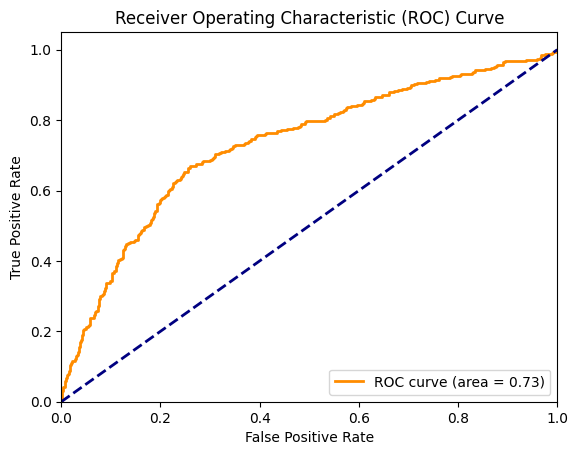

Accuracy on Test Data: 72.88%
Confusion Matrix:
 [[1146  399]
 [ 103  203]]
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.74      0.82      1545
           1       0.34      0.66      0.45       306

    accuracy                           0.73      1851
   macro avg       0.63      0.70      0.63      1851
weighted avg       0.82      0.73      0.76      1851

ROC AUC on Test Data: 0.73


In [ ]:
# Support Vector Machine
from sklearn.svm import SVC
model = SVC(kernel='linear', C=1)
trainer(model, upsampled_train_data, Test_data)

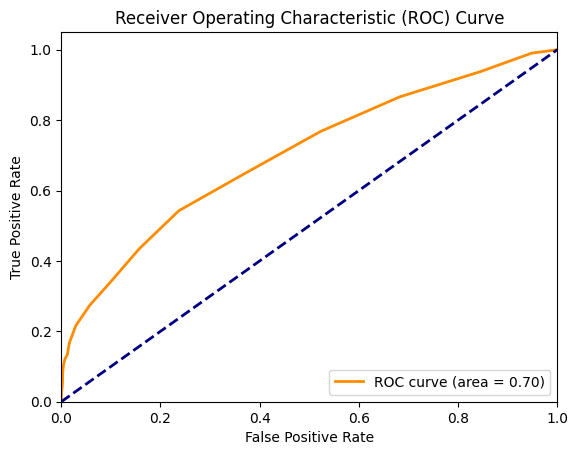

Accuracy on Test Data: 84.87%
Confusion Matrix:
 [[1520   25]
 [ 255   51]]
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.98      0.92      1545
           1       0.67      0.17      0.27       306

    accuracy                           0.85      1851
   macro avg       0.76      0.58      0.59      1851
weighted avg       0.83      0.85      0.81      1851

ROC AUC on Test Data: 0.70


In [ ]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=20, random_state=42)
trainer(model, upsampled_train_data, Test_data)

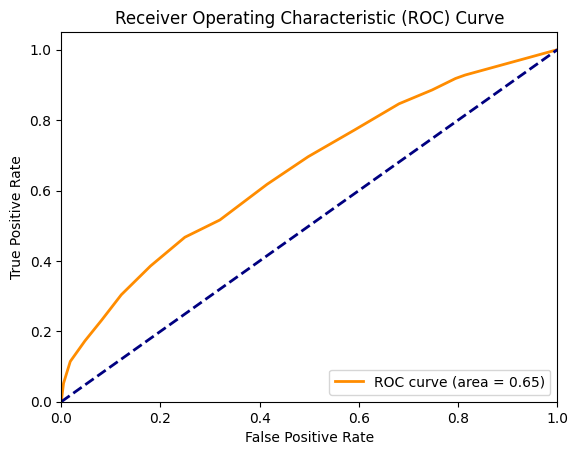

Accuracy on Test Data: 65.32%
Confusion Matrix:
 [[1051  494]
 [ 148  158]]
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.68      0.77      1545
           1       0.24      0.52      0.33       306

    accuracy                           0.65      1851
   macro avg       0.56      0.60      0.55      1851
weighted avg       0.77      0.65      0.69      1851

ROC AUC on Test Data: 0.65


In [ ]:
# K nearest neghbours
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=15)
trainer(model, upsampled_train_data, Test_data)

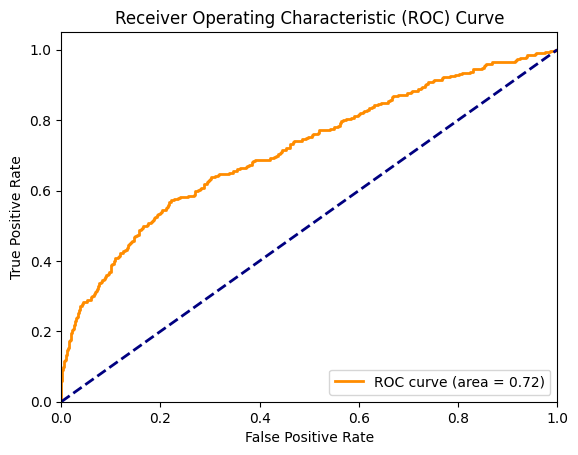

Accuracy on Test Data: 83.25%
Confusion Matrix:
 [[1452   93]
 [ 217   89]]
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.94      0.90      1545
           1       0.49      0.29      0.36       306

    accuracy                           0.83      1851
   macro avg       0.68      0.62      0.63      1851
weighted avg       0.81      0.83      0.81      1851

ROC AUC on Test Data: 0.72


In [ ]:
# Xgboost
import xgboost as xgb
model = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    use_label_encoder=False,  # To avoid a warning in newer versions
)
trainer(model, upsampled_train_data, Test_data)

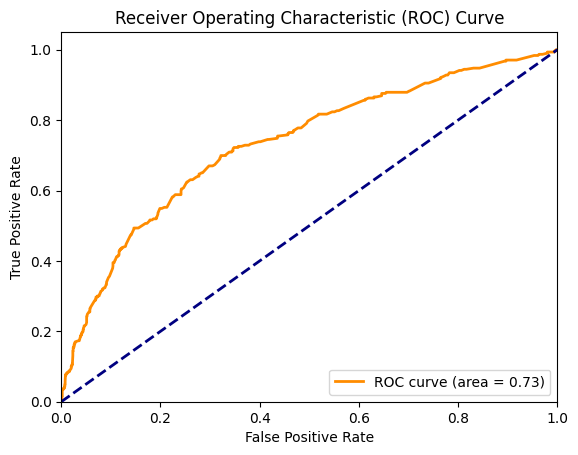

Accuracy on Test Data: 70.88%
Confusion Matrix:
 [[1116  429]
 [ 110  196]]
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.72      0.81      1545
           1       0.31      0.64      0.42       306

    accuracy                           0.71      1851
   macro avg       0.61      0.68      0.61      1851
weighted avg       0.81      0.71      0.74      1851

ROC AUC on Test Data: 0.73


In [ ]:
# Adaboost
from sklearn.ensemble import AdaBoostClassifier
model = AdaBoostClassifier(n_estimators=15, random_state=42)
trainer(model, upsampled_train_data, Test_data)

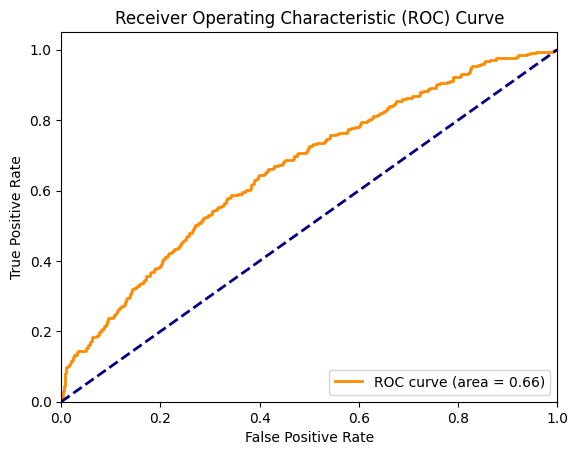

Accuracy on Test Data: 60.72%
Confusion Matrix:
 [[927 618]
 [109 197]]
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.60      0.72      1545
           1       0.24      0.64      0.35       306

    accuracy                           0.61      1851
   macro avg       0.57      0.62      0.53      1851
weighted avg       0.79      0.61      0.66      1851

ROC AUC on Test Data: 0.66


In [ ]:
# Naive Bayes
from sklearn.naive_bayes import BernoulliNB
model = BernoulliNB()
trainer(model, upsampled_train_data, Test_data)

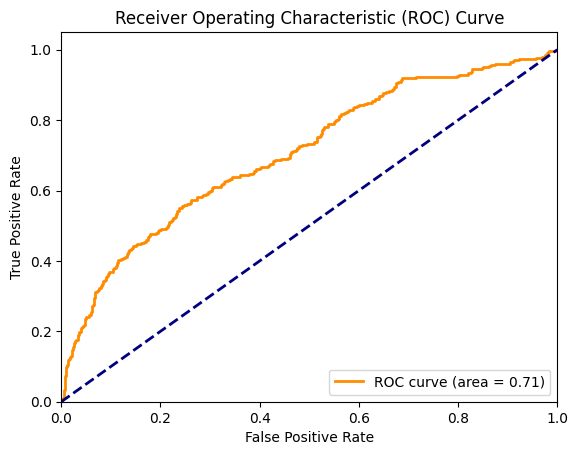

Accuracy on Test Data: 81.63%
Confusion Matrix:
 [[1402  143]
 [ 197  109]]
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.91      0.89      1545
           1       0.43      0.36      0.39       306

    accuracy                           0.82      1851
   macro avg       0.65      0.63      0.64      1851
weighted avg       0.80      0.82      0.81      1851

ROC AUC on Test Data: 0.71


In [19]:
# Multi-layer Perceptron
from sklearn.neural_network import MLPClassifier
model = MLPClassifier(hidden_layer_sizes=(1024, 2048), max_iter=1000, random_state=42)
trainer(model, upsampled_train_data, Test_data)